In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from utils import *
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

R = Rita()

In [2]:
df = pd.read_csv('../data/customer_segmentation.csv')

In [3]:
from sklearn.preprocessing import FunctionTransformer

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create main pipeline
main_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('var_threshold', VarianceThreshold(threshold=0.1)),
])

# Fit and transform the data
data_processed = main_pipeline.fit_transform(df)

In [4]:
def kmeans_diagnostic(data,clusters_range,mode='basic',theme='dark'):
    
    # theme definition
    if theme=='dark':
        bg = '#242728'
        lbl = '#eaeaea'
    else:
        bg = '#eaeaea'
        lbl = '#242728'
    
    # lists for basic mode
    sil = []
    elb = []
    
    ''' Basic mode'''
    if mode=='basic':
        
        fig, ax = plt.subplots(ncols=3,figsize=(15,5))
        fig.tight_layout(pad=2)
        fig.set_facecolor(bg)
        
        km = KMeans(init='k-means++',n_init=12,max_iter=100)
        # distorsion: mean sum of squared distances to centers
        elb = KElbowVisualizer(km,k=clusters_range,ax=ax[0],locate_elbow=True)
        elb.fit(data)
        ax[0].legend(loc='upper left')
        ax[0].set_title('Distortion score Elbow for KMeans Clustering')
        # silhouette: mean ratio of intra-cluster and nearest-cluster distance
        sil = KElbowVisualizer(km,k=clusters_range,metric='silhouette',locate_elbow=True,ax=ax[1])
        sil.fit(data)
        ax[1].legend(loc='upper left')
        ax[1].set_title('Silhouette score Elbow for KMeans Clustering')
        # calinski_harabasz: ratio of within to between cluster dispersion
        cal = KElbowVisualizer(km,k=clusters_range,metric='calinski_harabasz',locate_elbow=True,ax=ax[2])
        cal.fit(data)
        ax[2].legend(loc='upper left')
        ax[2].set_title('Calinkski Harabasz score Elbow for KMeans Clustering')
        
        fig.show()
        
    ''' Advanced mode'''   
    if mode=='advanced':
        
        # Calculate the number of rows needed
        num_rows = (len(clusters_range) + 1) // 2  # This will round up to the nearest integer

        # Create a figure with 4 columns and the calculated number of rows
        fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5*num_rows))
        fig.tight_layout(pad=3)
        fig.set_facecolor(bg)

        for idx, nclstr in enumerate(clusters_range):
            row = idx // 2
            col = (idx % 2) * 2  # This will alternate between 0 and 2
            
            # fitting kmeans
            km = KMeans(n_clusters=nclstr, init='k-means++', n_init=12, max_iter=100)
            
            # Calculate silhouette score
            silhouette_avg = round(silhouette_score(data, km.fit_predict(data)), 4)
            
            # silhouette coefficient plot
            silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=axes[row, col])
            silhouette.fit(data)
            
            # intercluster distance plot
            icd = InterclusterDistance(km, ax=axes[row, col+1], legend_loc='lower left')
            icd.fit(data)

            # Add a title in the middle of the cell
            middle_ax = fig.add_subplot(num_rows, 2, idx+1, frame_on=False)
            middle_ax.set_xticks([])
            middle_ax.set_yticks([])
            middle_ax.set_title(f'Clustering diagnostic on {nclstr} clusters\nASS: {silhouette_avg}', 
                                fontsize=12, weight='bold', color=lbl, y=1.0)
            
        # Remove any unused subplots
        for row in range(num_rows):
            if row * 2 + 1 >= len(clusters_range):
                fig.delaxes(axes[row, 2])
                fig.delaxes(axes[row, 3])

        plt.tight_layout()
        plt.show()
            

    return

In [5]:
# kmeans_diagnostic(data_processed,range(2,10),mode='basic',theme='white')

In [6]:
# kmeans_diagnostic(data_processed,range(5,9),mode='advanced',theme='dark')

  File "C:\Users\vcaminic\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(max_iter=100, n_clusters=6, n_init=12))

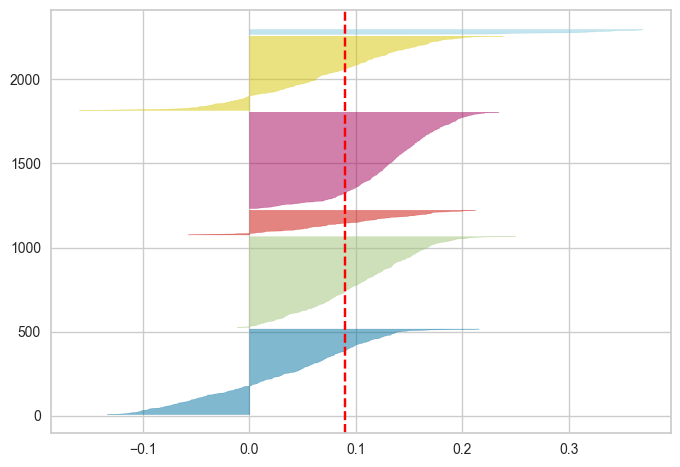

In [7]:
km = KMeans(n_clusters=6, init='k-means++', n_init=12, max_iter=100)

# Calculate silhouette score
silhouette_avg = round(silhouette_score(data_processed, km.fit_predict(data_processed)), 4)

# silhouette coefficient plot
silhouette = SilhouetteVisualizer(km, colors='yellowbrick')
silhouette.fit(data_processed)

In [8]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(data_processed)

# Add cluster labels to the original dataframe
res = df.copy()
res['cluster'] = y_kmeans

# Examine the cluster assignments
print(res.groupby('cluster').size())

cluster
0    118
1    516
2    478
3    155
4    424
5     30
6    519
dtype: int64


In [10]:
res.to_csv('cluster_segmentation.csv',index=False)